## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.

**Note: For the online lab, data has been collected and provided for you. If you would like to try locally please do so! Please continue instructions from the continue point.**
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data

**Continue Point**
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` in the project to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

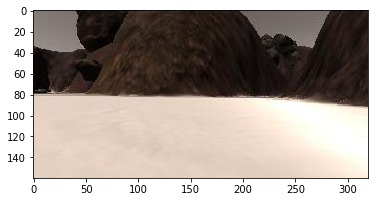

In [3]:
# To use dataset provided:
# path = '../test_dataset/IMG/*'

# To use my dataset recoreder from simulation:
path = '../test_dataset2/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image);


## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

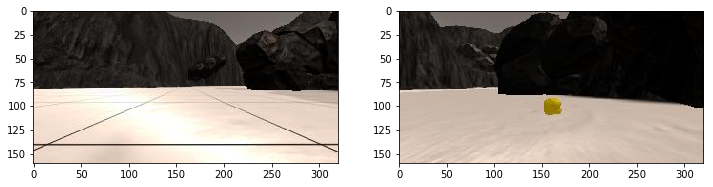

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img);
plt.subplot(122)
plt.imshow(rock_img);

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

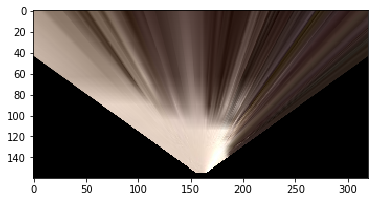

In [5]:
# Define a function to perform a perspective transform

# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)

# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates

# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(image, source, destination)
plt.imshow(warped);

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Suggestion:** Think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  
**Beware:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

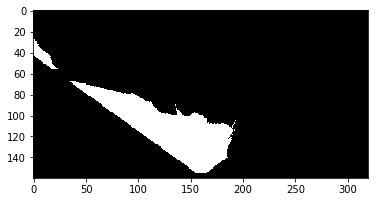

In [6]:
# Identify pixels above the threshold

# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray');

In [7]:
# Code for experimentation with different configurations of color filters working in the HSV color space.

def nothing(x):
    pass

# Windows that has the sliders to congigure the filter
cv2.namedWindow('image')
cv2.createTrackbar('Hue Min', 'image', 0, 255, nothing)
cv2.createTrackbar('Hue Max', 'image', 0, 255, nothing)
cv2.createTrackbar('Sat Min', 'image', 0, 255, nothing)
cv2.createTrackbar('Sat Max', 'image', 0, 255, nothing)
cv2.createTrackbar('Val Min', 'image', 0, 255, nothing)
cv2.createTrackbar('Val Max', 'image', 0, 255, nothing)
# set initial values
cv2.setTrackbarPos('Hue Min', 'image', 0)
cv2.setTrackbarPos('Hue Max', 'image', 255)
cv2.setTrackbarPos('Sat Min', 'image', 65)
cv2.setTrackbarPos('Sat Max', 'image', 255)
cv2.setTrackbarPos('Val Min', 'image', 0)
cv2.setTrackbarPos('Val Max', 'image', 160)

# path = '../test_dataset/IMG/*'
# My dataset:
path = '../test_dataset2/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list) - 1)
# uncomment to get differents images
# idx +=1
frame = cv2.imread(img_list[idx])


while(1):
    # Change to HSV color space.
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # The max and min values of H,S and V are stored depending on the sliders positions
    hMin = cv2.getTrackbarPos('Hue Min', 'image')
    hMax = cv2.getTrackbarPos('Hue Max', 'image')
    sMin = cv2.getTrackbarPos('Sat Min', 'image')
    sMax = cv2.getTrackbarPos('Sat Max', 'image')
    vMin = cv2.getTrackbarPos('Val Min', 'image')
    vMax = cv2.getTrackbarPos('Val Max', 'image')

    # Array with min/max positions
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Color detection
    mask = cv2.inRange(hsv, lower, upper)
    roi = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    roi[70:, :] = 1

    mask_roi = mask * roi
    threshed = cv2.bitwise_and(frame, frame, dst=None, mask=mask_roi)

    # Show results 
    cv2.imshow('camara', frame)
    cv2.imshow('thresed', threshed)
    cv2.imshow('mask', mask)
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break
    elif k == 97:
        idx = np.random.randint(0, len(img_list) - 1)
        frame = cv2.imread(img_list[idx])

cv2.destroyAllWindows()

In [33]:
def color_thresh_hsv(img, low_thresh=(20, 85, 85), high_thresh=(35, 255, 255), inv=False, roi=None):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsv, low_thresh, high_thresh, dst=None)
    
    if roi is not None:
        mask = roi * mask
    if inv is True:
        mask = -(mask - 1)
#     mask = cv2.blur(mask,(7,7))
    res = cv2.bitwise_and(img, img, dst=None, mask=mask)
    return res, mask

In [34]:
# Some test to undestand de hsv color space
rgb_c = np.array([[[160,160,160]]]).astype('uint8')
hsv_c = cv2.cvtColor(rgb_c, cv2.COLOR_RGB2HSV)
print(hsv_c)

[[[  0   0 160]]]


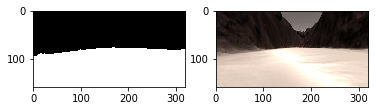

In [35]:
low_n_thresh = (0, 0, 160)
high_n_thresh = (255, 120, 255)
roi = np.zeros((image.shape[0],image.shape[1]),dtype=np.uint8)
roi[70:,:] = 1
threshed, mask = color_thresh_hsv(image,low_n_thresh,high_n_thresh,roi=roi)
plt.subplot(1,2,1)
plt.imshow(mask, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(image)

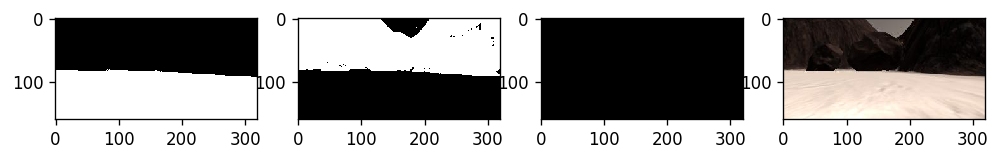

In [36]:
def world_segmentation(img,
                       l_r_thresh=(20, 65, 65),
                       h_r_thresh=(35, 255, 255),
                       l_n_thresh=(0, 0, 160),
                       h_n_thresh=(255, 120, 255),
                       roi=None,
                       l_o_thresh=(0, 40, 0),
                       h_o_thresh=(255, 255, 120)):
    res, mask_r = color_thresh_hsv(img, l_r_thresh, h_r_thresh)
    res, mask_n = color_thresh_hsv(img, l_n_thresh, h_n_thresh, roi=roi)
    res, mask_o = color_thresh_hsv(img, l_o_thresh, h_o_thresh)
#     res, mask_o = color_thresh_hsv(img, l_n_thresh, h_n_thresh,roi=roi,inv=True)
    return mask_n, mask_o, mask_r

idx = np.random.randint(0, len(img_list) - 1)
image = plt.imread(img_list[idx])
roi1 = np.zeros((image.shape[0],image.shape[1]),dtype=np.uint8)
roi1[70:,:] = 1

T, O, R = world_segmentation(image,roi=roi1)

plt.figure(figsize=(10,10),dpi=120)
plt.subplot(141)
plt.imshow(T,'gray');
plt.subplot(142)
plt.imshow(O,'gray');
plt.subplot(143)
plt.imshow(R,'gray');
plt.subplot(144)
plt.imshow(image,'gray');


## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

In [37]:
def rad2deg(rad):
    # radian to degree transform
        return rad * 180 / np.pi

def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the
    # center bottom of the image.
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle)
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    yaw_r = yaw * np.pi / 180
    # Apply a rotation
    xpix_rotated = xpix * np.cos(yaw_r) - ypix * np.sin(yaw_r)
    ypix_rotated = xpix * np.sin(yaw_r) + ypix * np.cos(yaw_r)
    # Return the result
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = xpix_rot / scale + xpos
    ypix_translated = ypix_rot / scale + ypos
    # Return the result
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work


def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

def get_polar_points(Rover):
    if Rover.nav_dists is not None:
        dist = Rover.nav_dists
    else:
        dist = 0
    if Rover.nav_angles is not None:
        ang = Rover.nav_angles
    else:
        ang = 0
    Rover.nav_angles
    return np.array((dist, ang)).T


def get_frontal_distance(polar_points, arc=10):
    central_view = [d for d, a in polar_points if abs(rad2deg(a)) < arc]
    return np.array(central_view)

def get_near_periferics(polar_points, alpha):
    near_angles = [a for d, a in polar_points if d < alpha]
    return np.array(near_angles)

def side_areas(Rover):
    i = 0
    d = 0
    if len(Rover.nav_angles) != 0:
        for a in Rover.nav_angles:
            if a > 0:
                i += 1
            else:
                d += 1
        return (1.0 * i / len(Rover.nav_angles), 1.0 * d / len(Rover.nav_angles))
    else:
        return (0, 0)



270
mean:  35.56849838765066
desv:  9.646054902920316
steer:  40.39152583911083
frontal dist: 31.04834939252005
side areas i: 1.0
side areas d: 0.0


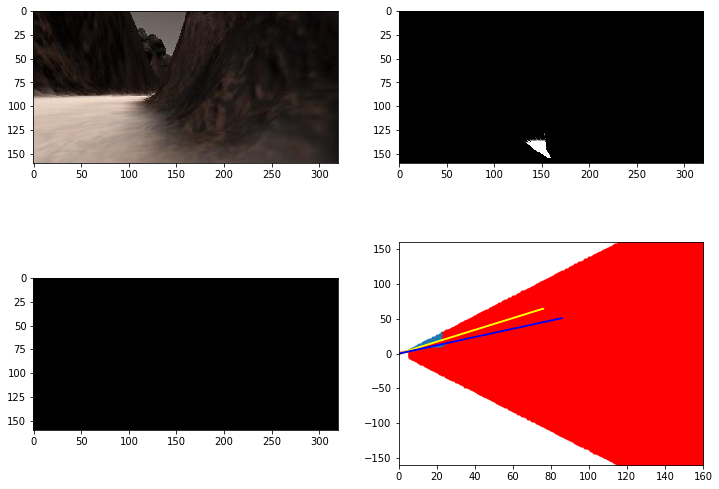

In [39]:
# Grab another random image
idx = np.random.randint(0, len(img_list)-1)

image = mpimg.imread(img_list[idx-90])
# idx=0
roi = np.zeros((image.shape[0],image.shape[1]),dtype=np.uint8)
roi[70:,:] = 1 

mask_n,mask_o,mask_r = world_segmentation(image,roi=roi)

warped_n = perspect_transform(mask_n, source, destination)
warped_r = perspect_transform(mask_r, source, destination)
warped_o = perspect_transform(mask_o, source, destination)

colored_warped = np.zeros_like(image)
colored_warped[:,:,0] = mask_o*255
colored_warped[:,:,1] = mask_r*255
colored_warped[:,:,2] = mask_n*255
warped = perspect_transform(colored_warped, source, destination)


# Calculate 
xpix, ypix = rover_coords(warped_n)
xpix2, ypix2 = rover_coords(warped_o)

dist, angles = to_polar_coords(xpix, ypix)
da = np.array((dist,angles)).T
s_ang = 0
n = 0
near_a = get_near_periferics(da,100)
mean_dir = np.mean(near_a)
desv = np.sqrt(near_a.var())
# mean_dir = np.mean(angles)
# desv = np.sqrt(angles.var())
offset = desv*0.5
# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped_n,cmap='gray')
plt.subplot(223)
plt.imshow(warped, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.plot(xpix2, ypix2, '.r')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
dx_arrow1 = arrow_length * np.cos(mean_dir+offset)
dy_arrow1 = arrow_length * np.sin(mean_dir+offset)
dx_arrow2 = arrow_length * np.cos(mean_dir-offset)
dy_arrow2 = arrow_length * np.sin(mean_dir-offset)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.arrow(0, 0, dx_arrow1, dy_arrow1, color='yellow', zorder=2, head_width=0, width=1)
plt.arrow(0, 0, dx_arrow2, dy_arrow2, color='blue', zorder=2, head_width=0, width=1)
tita = rad2deg((mean_dir+offset))

print(len(near_a))
print('mean: ', rad2deg(mean_dir))
print('desv: ', rad2deg(desv))
print('steer: ', tita)
print('frontal dist:', np.min(get_frontal_distance(da,15)))

# Testing side areas
i=0
d=0
for a in near_a:
            if a > 0:
                i += 1
            else:
                d += 1

print('side areas i:', 1.0*i/len(near_a))
print('side areas d:', 1.0*d/len(near_a))

## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [30]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change this path to your data directory
# df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal=',')

# My data:
df = pd.read_csv('../test_dataset2/robot_log.csv', delimiter=';', decimal=',')


csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [31]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    src = source
    dst = destination
    scale = 10
    roi = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)
    roi[70:,:] = 1 
    # img_path = data.images[data.count]
    # img = mpimg.imread(img_path)
    world_size = data.worldmap.shape[0]
    # 2) Apply perspective transform
#     p_img = perspect_transform(img, src, dst)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    mask_t, mask_o, mask_r = world_segmentation(img,roi=roi)
    w_mask_t = perspect_transform(mask_t, src, dst)
    w_mask_r = perspect_transform(mask_r, src, dst)
    w_mask_o = perspect_transform(mask_o, src, dst)

    # 4) Convert thresholded image pixel values to rover-centric coords
    t_xpix, t_ypix = rover_coords(w_mask_t)
    o_xpix, o_ypix = rover_coords(w_mask_o)
    r_xpix, r_ypix = rover_coords(w_mask_r)
    # 5) Convert rover-centric pixel values to world coords
    xpos = np.float_(data.xpos[data.count])
    ypos = np.float_(data.ypos[data.count])
    yaw = np.float_(data.yaw[data.count])
    wrd_t_xpix, wrd_t_ypix = pix_to_world(t_xpix[120:],
                                          t_ypix[120:],
                                          xpos,
                                          ypos,
                                          yaw,
                                          world_size,
                                          scale)
    wrd_o_xpix, wrd_o_ypix = pix_to_world(o_xpix[120:],
                                          o_ypix[120:],
                                          xpos,
                                          ypos,
                                          yaw,
                                          world_size,
                                          scale)
    wrd_r_xpix, wrd_r_ypix = pix_to_world(r_xpix[120:], r_ypix[120:],
                                          xpos, ypos,
                                          yaw, world_size, scale)
    # 6) Update worldmap (to be displayed on right side of screen)
    # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
    #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
    #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    data.worldmap[wrd_o_ypix, wrd_o_xpix, 0] += 1
    data.worldmap[wrd_r_ypix, wrd_r_xpix, 1] += 1
    data.worldmap[wrd_t_ypix, wrd_t_xpix, 2] += 1
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.3, 0.7)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)
#         # Colored warped img
    colored_warped = np.zeros_like(warped)    
    colored_warped[:,:,0] = w_mask_o*255
    colored_warped[:,:,1] = w_mask_r*255
    colored_warped[:,:,2] = w_mask_t*255
    output_image[img.shape[0]:img.shape[0]+warped.shape[0], img.shape[1]:] = colored_warped
        

        # Then putting some text over the image
    cv2.putText(output_image,"My video", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping_mine.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
data.count = -2 # extra modification beacuse it dosen't work with -1
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

OSError: No such file: '/media/juan/Datos/Repositorios/Udacity-Robo-nanodegree/src/rover/ex_6/test_dataset2/IMG/robocam_2018_01_16_21_02_42_134.jpg'

### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [17]:
output = '../output/test_mapping_mine.mp4'
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output/test_mapping_mine.mp4'))

In [18]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))